In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
dir_plots = './plots/'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_hr = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc_hr.drop(df_acc_hr.loc[df_acc_hr['measurementday'] > 7].index, inplace=True)
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [3]:
df1 = df_acc_hr[["mergeid", "measurementday", "GGIR_mean_ENMO_hour","GGIR_N_valid_hours", "hour", "OxCGRT_stay_at_home", "OxCGRT_stringency_index"]].copy()
df = df1.drop(df1.loc[df1['GGIR_N_valid_hours'] < 0.75].index)
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [4]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [5]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [6]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_bmi_num(df)
df = df.drop(df.loc[df['bmi'] < 15].index)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)


In [7]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [8]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [9]:
df[['Hypertension', 'Diabetes', 'OA']].value_counts() # check, that d group assoc still works

Hypertension  Diabetes  OA
0             0         0     60072
1             0         0     38088
              1         0     10392
0             0         1      7584
              1         0      7128
1             0         1      7128
              1         1      2640
0             1         1       864
dtype: int64

In [10]:
df[['d1' ,'control']].value_counts() # check for target groups

d1  control
0   1          60072
1   0          38088
0   0          35736
dtype: int64

In [11]:
groups = ["d1", "d2", "d3", "d4", "d5", "d6", "d7"]
categorie = [1,0,-1]

for g in groups:
    conditions = [
        (df[g] == 1) & (df['control'] == 0),
        (df['control'] == 1),
        (df[g] == 0) & (df['control'] == 0)
    ]
    df[f'{g}_strict'] = np.select(conditions,categorie,default=0)
    #df.drop(df.loc[df[f'{g}_strict'] == -1].index)

#df['d1_strict'] = np.select(conditions,categorie,default=0)
#df.drop(df.loc[df['d1_strict'] == -1].index)

In [12]:
df[['d1_strict', 'control']].value_counts() # identical to target groups -> works

d1_strict  control
 0         1          60072
 1         0          38088
-1         0          35736
dtype: int64

In [13]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

run d1_strict: dropped 35736 of 133896 samples (73.3%)
run d2_strict: dropped 66696 of 133896 samples (50.2%)
run d3_strict: dropped 66240 of 133896 samples (50.5%)
run d4_strict: dropped 63432 of 133896 samples (52.6%)
run d5_strict: dropped 66696 of 133896 samples (50.2%)
run d6_strict: dropped 72960 of 133896 samples (45.5%)
run d7_strict: dropped 71184 of 133896 samples (46.8%)


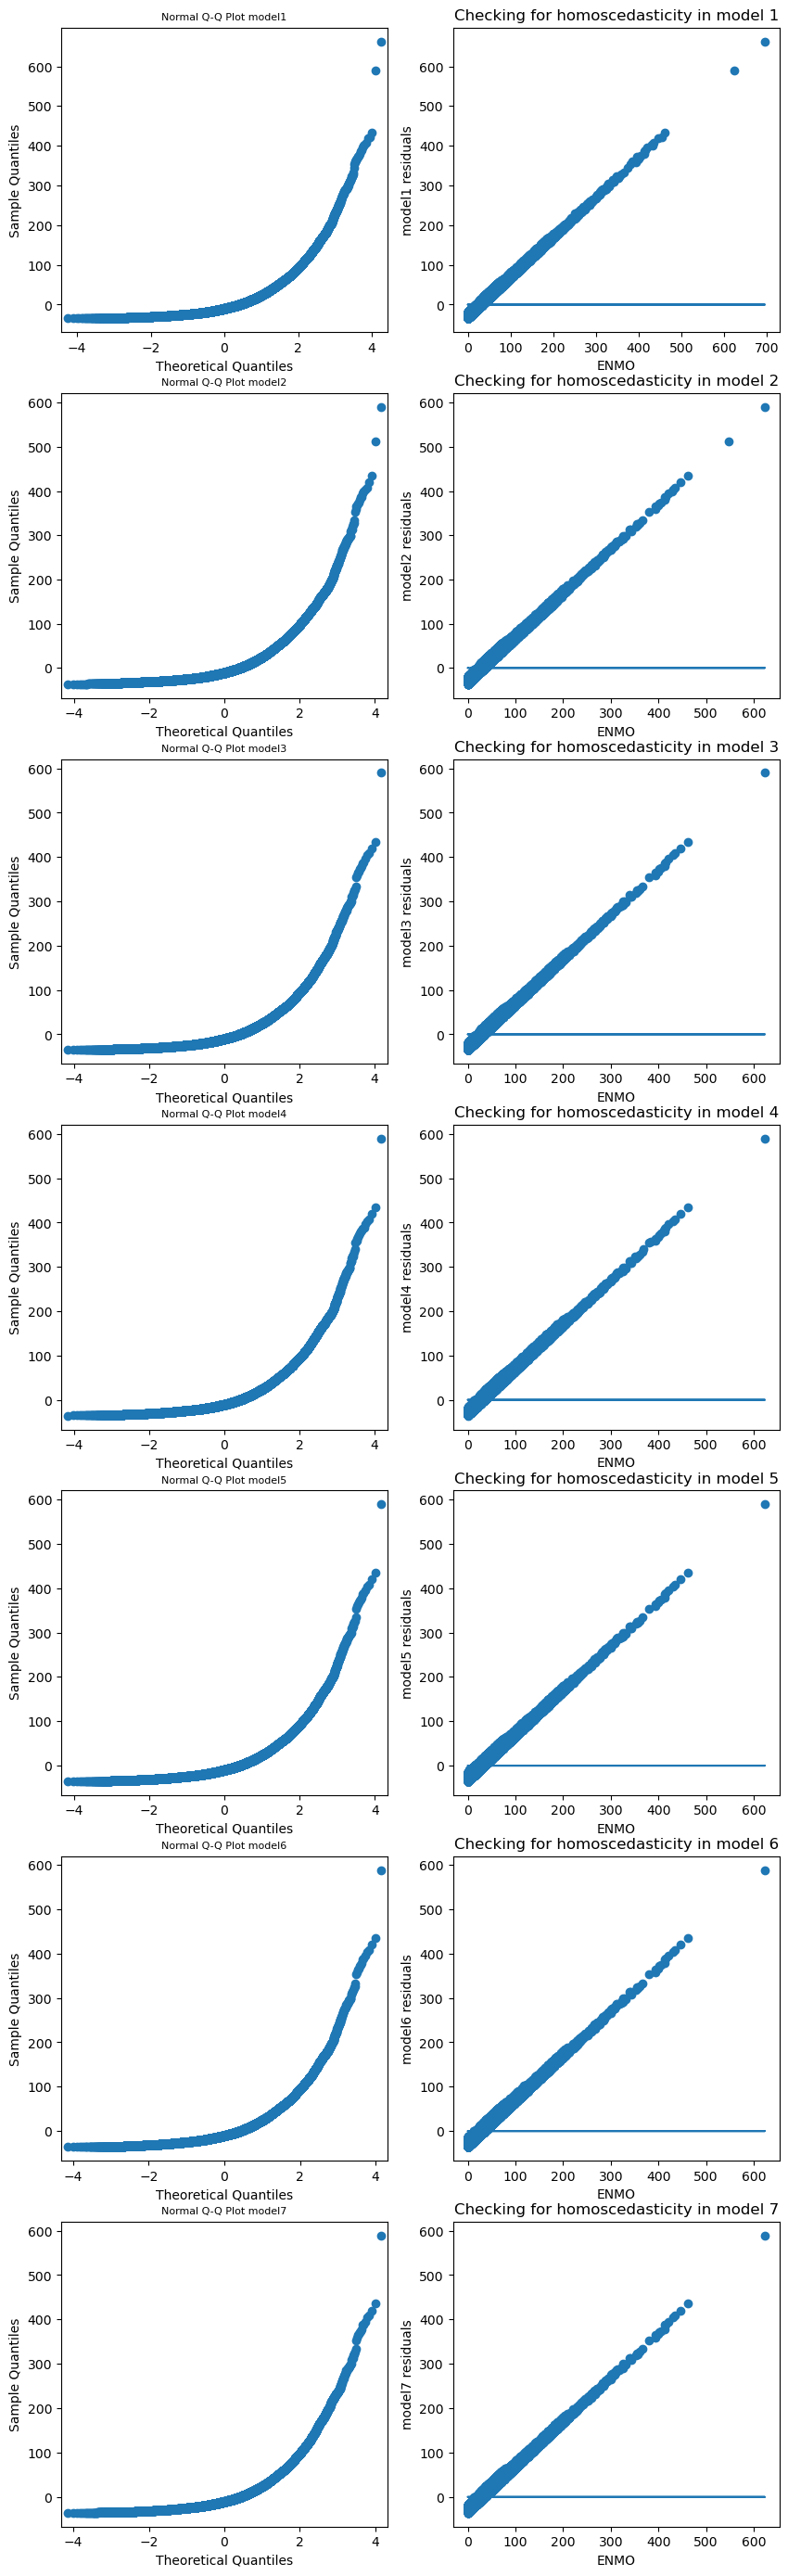

In [14]:
fig, ax = plt.subplots(7,2, figsize=(10,35))
result = pd.DataFrame()
models = []
vif = []

for i, g in enumerate(groups):
    g = f'{g}_strict'
    _df = df.drop(df.loc[df[g] == -1].index)
    
    # print # of dropped samples -> should match -1 samples from above. does -> works
    print(f'run {g}: dropped {len(df)- len(_df)} of {len(df)} samples ({len(_df)/len(df):.1%})') 
    
    _YVar = _df["GGIR_mean_ENMO_hour"] #dependent

    _XVar = _df[[g, "measurementday", "age", "female", "bmi"]] #independent
    _XVar1 = sm.add_constant(_XVar)
    _model = sm.OLS(_YVar, _XVar1).fit()
    #_models = models.append(_model)
    as_html =_model.summary(slim=True).tables[1].as_html() 
    res = pd.read_html(as_html, header=0, index_col=0)[0]

    residuals = _model.resid
    sm.qqplot(residuals, ax=ax[i,0])
    ax[i,0].set_title(f"Normal Q-Q Plot model{i+1}",fontsize=8)

    ax[i,1].scatter(_YVar,residuals)
    ax[i,1].set_xlabel("ENMO")
    ax[i,1].set_ylabel(f"model{i+1} residuals")
    ax[i,1].set_title(f"Checking for homoscedasticity in model {i+1}")
    ax[i,1].plot(_YVar, [0]*len(_YVar))

    _vif = pd.DataFrame()
    _vif["VIF Factor"] = [variance_inflation_factor(_XVar1.values, i) for i in range(_XVar1.shape[1])]
    _vif["features"] = _XVar1.columns
    _vif.round(1)
    vif.append(_vif)

    result = pd.concat([result, res])
vif = pd.concat(vif)

In [15]:
result.reset_index().groupby(by='index').mean() # mean performance across regressions
#result.reset_index().groupby(by='index').mean().to_excel("results_hour.xlsx")

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,-0.369614,0.015286,-24.075571,0.000000,-0.399714,-0.339429
bmi,-0.235900,0.031286,-7.769429,0.000000,-0.297000,-0.174571
const,60.955143,1.469429,41.786000,0.000000,58.075286,63.835000
d1_strict,0.125700,0.231000,0.543000,0.587000,-0.328000,0.579000
d2_strict,3.726400,0.443000,8.417000,0.000000,2.859000,4.594000
d3_strict,0.402600,0.417000,0.967000,0.334000,-0.414000,1.219000
d4_strict,-1.182900,0.384000,-3.083000,0.002000,-1.935000,-0.431000
d5_strict,-2.694600,0.436000,-6.177000,0.000000,-3.550000,-1.840000
d6_strict,-8.699600,1.160000,-7.498000,0.000000,-10.974000,-6.426000


In [16]:
result.reset_index().groupby(by='index').var() # check var to make sure constants are stable (age, bmi, ..) -> they are

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,0.001281,0.000003,1.945981,0.000000,0.001460,0.001115
bmi,0.005097,0.000013,8.645360,0.000000,0.004629,0.005641
const,6.520789,0.019053,16.391532,0.000000,6.052370,7.136065
d1_strict,NaN,NaN,NaN,NaN,NaN,NaN
d2_strict,NaN,NaN,NaN,NaN,NaN,NaN
d3_strict,NaN,NaN,NaN,NaN,NaN,NaN
d4_strict,NaN,NaN,NaN,NaN,NaN,NaN
d5_strict,NaN,NaN,NaN,NaN,NaN,NaN
d6_strict,NaN,NaN,NaN,NaN,NaN,NaN


linear relationship

In [17]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, ax=None, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)

Text(0.5, 1.0, 'female')

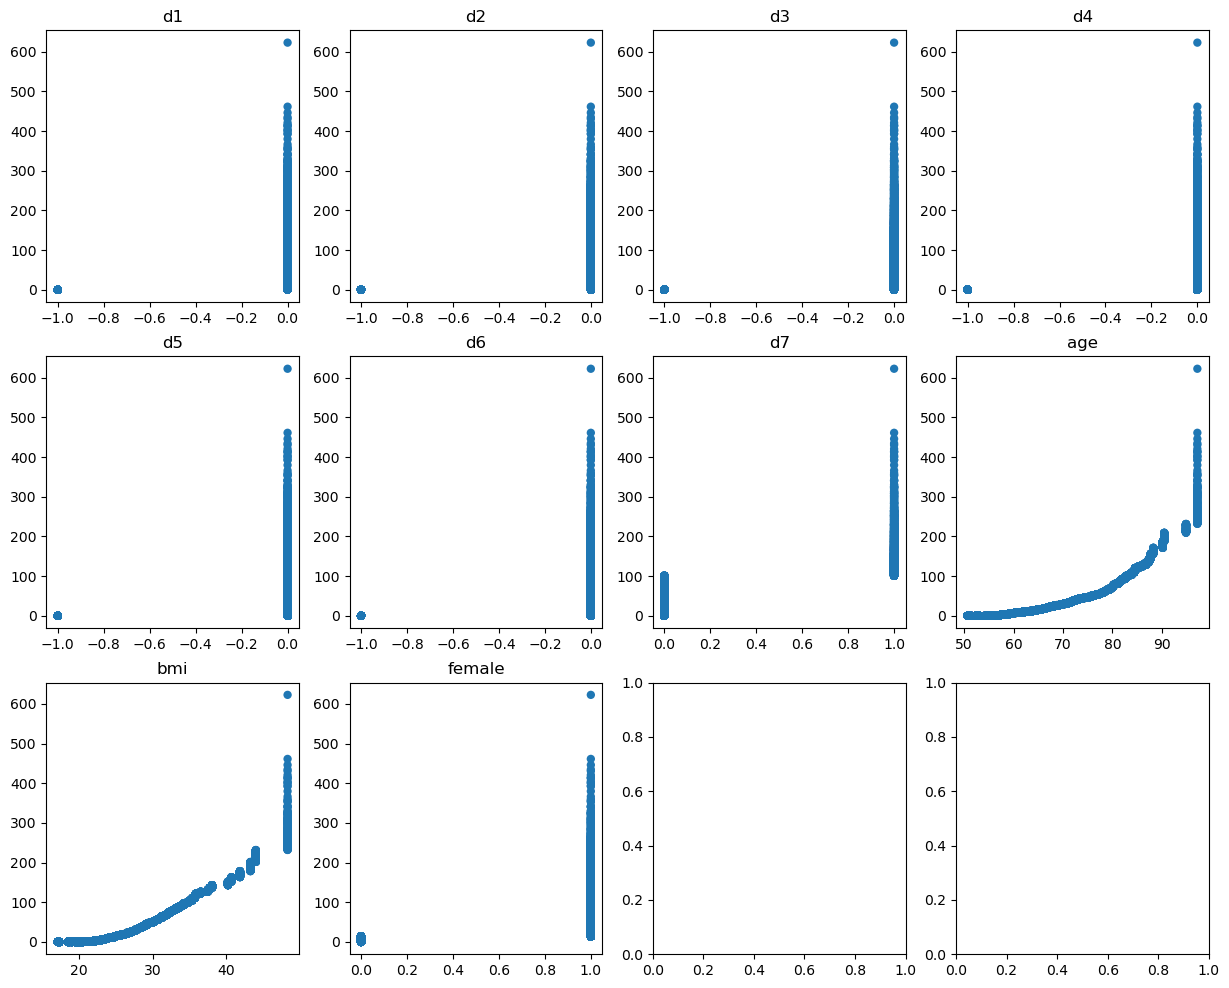

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
qqplot(_df['d1_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[0,0])
ax[0,0].set_title("d1")
qqplot(_df['d2_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[0,1])
ax[0,1].set_title("d2")
qqplot(_df['d3_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[0,2])
ax[0,2].set_title("d3")
qqplot(_df['d4_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[0,3])
ax[0,3].set_title("d4")
qqplot(_df['d5_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[1,0])
ax[1,0].set_title("d5")
qqplot(_df['d6_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[1,1])
ax[1,1].set_title("d6")
qqplot(_df['d7_strict'],_df["GGIR_mean_ENMO_hour"], ax=ax[1,2])
ax[1,2].set_title("d7")
qqplot(_df['age'],_df["GGIR_mean_ENMO_hour"], ax=ax[1,3])
ax[1,3].set_title("age")
qqplot(_df['bmi'],_df["GGIR_mean_ENMO_hour"], ax=ax[2,0])
ax[2,0].set_title("bmi")
qqplot(_df['female'],_df["GGIR_mean_ENMO_hour"], ax=ax[2,1])
ax[2,1].set_title("female")

Text(0.5, 1.0, 'female')

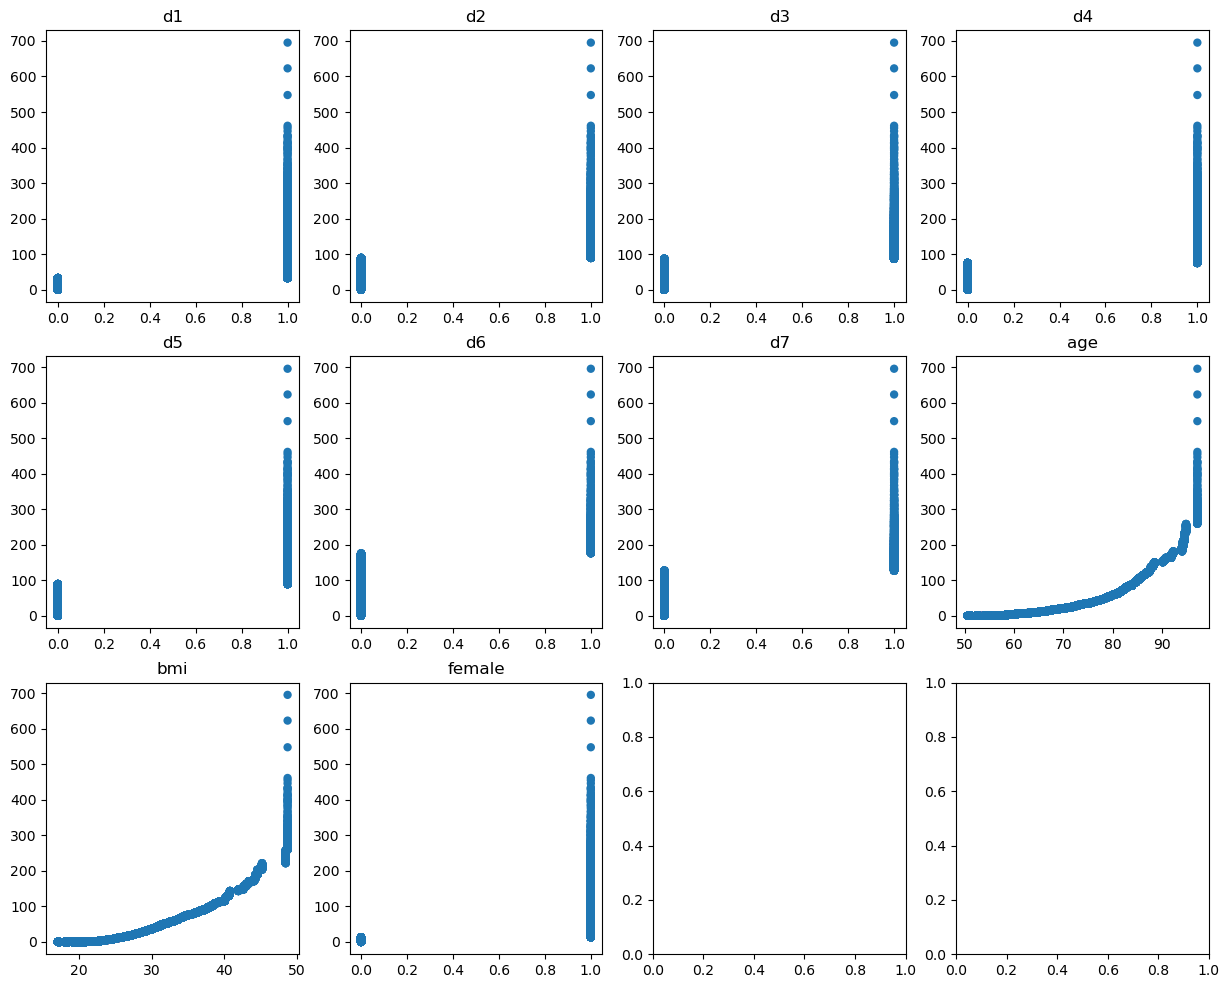

In [19]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
qqplot(df['d1'],df["GGIR_mean_ENMO_hour"], ax=ax[0,0])
ax[0,0].set_title("d1")
qqplot(df['d2'],df["GGIR_mean_ENMO_hour"], ax=ax[0,1])
ax[0,1].set_title("d2")
qqplot(df['d3'],df["GGIR_mean_ENMO_hour"], ax=ax[0,2])
ax[0,2].set_title("d3")
qqplot(df['d4'],df["GGIR_mean_ENMO_hour"], ax=ax[0,3])
ax[0,3].set_title("d4")
qqplot(df['d5'],df["GGIR_mean_ENMO_hour"], ax=ax[1,0])
ax[1,0].set_title("d5")
qqplot(df['d6'],df["GGIR_mean_ENMO_hour"], ax=ax[1,1])
ax[1,1].set_title("d6")
qqplot(df['d7'],df["GGIR_mean_ENMO_hour"], ax=ax[1,2])
ax[1,2].set_title("d7")
qqplot(df["age"],df["GGIR_mean_ENMO_hour"], ax=ax[1,3])
ax[1,3].set_title("age")
qqplot(df['bmi'],df["GGIR_mean_ENMO_hour"], ax=ax[2,0])
ax[2,0].set_title("bmi")
qqplot(df['female'],df["GGIR_mean_ENMO_hour"], ax=ax[2,1])
ax[2,1].set_title("female")
#plt.savefig(f'{dir_plots} Linear Assumtion_old')

'Older' version

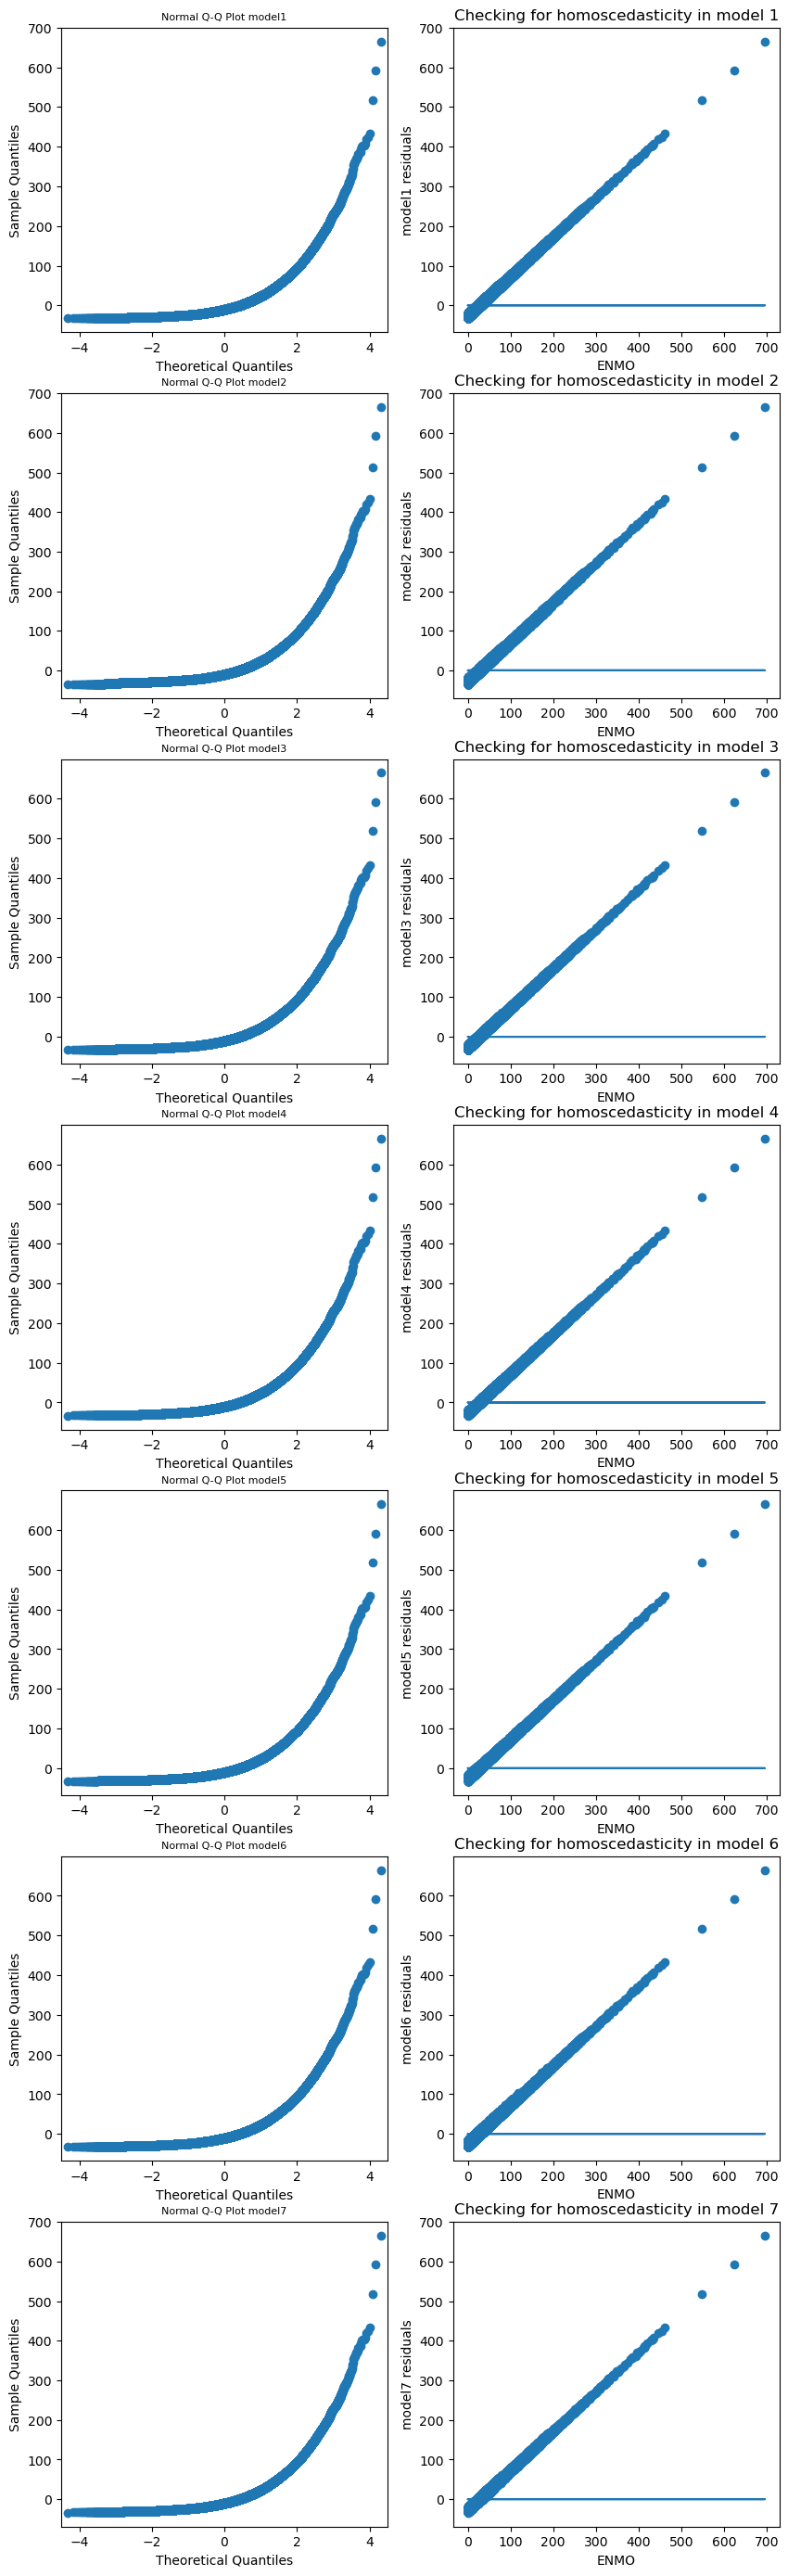

In [20]:
fig, ax = plt.subplots(7,2, figsize=(10,35))
result = pd.DataFrame()
vif = []

groups = ["d1", "d2", "d3", "d4", "d5", "d6", "d7"]

for i, g in enumerate(groups):
    _df = df[[g,"GGIR_mean_ENMO_hour","measurementday", "age", "female", "bmi"]].copy()

    _YVar = _df["GGIR_mean_ENMO_hour"]

    _XVar = _df[[g, "age", "female", "bmi"]] 
    _XVar1 = sm.add_constant(_XVar)
    _model = sm.OLS(_YVar, _XVar1).fit()
    
    as_html =_model.summary(slim=True).tables[1].as_html() 
    res = pd.read_html(as_html, header=0, index_col=0)[0]

    residuals = _model.resid
    sm.qqplot(residuals, ax=ax[i,0])
    ax[i,0].set_title(f"Normal Q-Q Plot model{i+1}",fontsize=8)

    ax[i,1].scatter(_YVar,residuals)
    ax[i,1].set_xlabel("ENMO")
    ax[i,1].set_ylabel(f"model{i+1} residuals")
    ax[i,1].set_title(f"Checking for homoscedasticity in model {i+1}")
    ax[i,1].plot(_YVar, [0]*len(_YVar))

    _vif = pd.DataFrame()
    _vif["VIF Factor"] = [variance_inflation_factor(_XVar1.values, i) for i in range(_XVar1.shape[1])]
    _vif["features"] = _XVar1.columns
    _vif.round(1)
    vif.append(_vif)

    result = pd.concat([result, res])
vif = pd.concat(vif)

In [21]:
result.reset_index().groupby(by='index').mean()

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,-0.242129,0.010000,-23.296000,0.000,-0.262429,-0.222000
bmi,-0.232814,0.019000,-12.360714,0.000,-0.269571,-0.195857
const,51.514314,0.962571,53.515714,0.000,49.627714,53.401143
d1,-0.047100,0.204000,-0.231000,0.818,-0.447000,0.353000
d2,4.052000,0.404000,10.031000,0.000,3.260000,4.844000
d3,-0.050200,0.393000,-0.128000,0.898,-0.821000,0.721000
d4,-1.947000,0.344000,-5.668000,0.000,-2.620000,-1.274000
d5,-3.761600,0.408000,-9.225000,0.000,-4.561000,-2.962000
d6,-9.538500,1.131000,-8.436000,0.000,-11.755000,-7.322000


In [22]:
result.reset_index().groupby(by='index').var()

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,0.000019,0.000000e+00,0.190415,0.0,0.000017,0.000019
bmi,0.000196,0.000000e+00,0.545789,0.0,0.000202,0.000198
const,0.326114,1.028571e-05,0.379068,0.0,0.325705,0.326332
d1,NaN,NaN,NaN,NaN,NaN,NaN
d2,NaN,NaN,NaN,NaN,NaN,NaN
d3,NaN,NaN,NaN,NaN,NaN,NaN
d4,NaN,NaN,NaN,NaN,NaN,NaN
d5,NaN,NaN,NaN,NaN,NaN,NaN
d6,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
vif

,VIF Factor,features
0,113.885826,const
1,1.036047,d1
2,1.055622,age
3,1.014633,female
4,1.039876,bmi
0,112.457185,const
1,1.004494,d2
2,1.036102,age
3,1.014349,female
4,1.023566,bmi


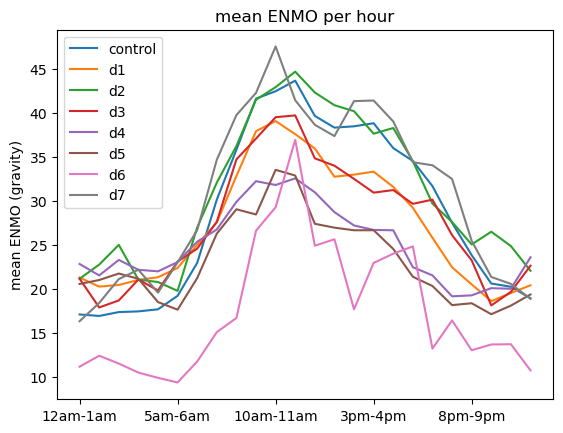

In [24]:
hour = (
    df.groupby(['hour', 'disease'])
    .GGIR_mean_ENMO_hour
    .agg(['mean'])
    .unstack()
)

hour['mean']['control'].plot()
hour['mean']['d1'].plot()
hour['mean']['d2'].plot()
hour['mean']['d3'].plot()
hour['mean']['d4'].plot()
hour['mean']['d5'].plot()
hour['mean']['d6'].plot()
hour['mean']['d7'].plot()
plt.ylabel("mean ENMO (gravity)")
plt.xlabel("")
plt.title("mean ENMO per hour")
plt.legend()
plt.savefig(f'{dir_plots} average ENMO per hour')